In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import copy
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
"""
data_csv is a list of 10 data frames holding a [2,] list for each symboL
the first one (for example data_csv[i][0] ) is the name of the symbol and
the second one (for example data_csv[i][1] ) is the data assosiated to it
"""
data_csv = []
i = 0
for filename in glob.glob('data/*.csv'):
    data_csv.append([filename[5:len(filename)-4],pd.read_csv(filename).drop("<TICKER>",1)])
    i+=1

In [18]:
data_frame = 2
features = data_csv[data_frame][1][['<OPEN>', '<CLOSE>', '<HIGH>', '<LOW>', '<VOL>']]
features.head()
# print(features.shape)

,<OPEN>,<CLOSE>,<HIGH>,<LOW>,<VOL>
0,4000.0,3704.0,4000.0,3600.0,172898994
1,3778.0,3778.0,3778.0,3778.0,10826496
2,3853.0,3853.0,3853.0,3853.0,26850133
3,3930.0,3930.0,3930.0,3930.0,31086849
4,4008.0,4008.0,4008.0,4008.0,40645528


In [19]:
def turn_to_windows(input,kernel):
    """
    Suppose that input is (T, F): T is the number of time steps and F is the number of features
    Then this function creates a list of data, label pairs in which data is (N, K, F) and label is (N, F)
    N is the number of data, label pairs

    Inputs:
    - input: (T, F)
    - kernel: scalar and we call it K

    Outputs:
    - data: (N, K, F)
    - labels: (N, F)
    """
    data = []
    labels = []
    for i in range(0,len(input)-kernel):
        data.append(input[i:i+kernel])
        labels.append(input[i+kernel])
    return np.array(data),np.array(labels)

In [20]:
"""
In this section we prepare the data that we are going to use later.
We have train data and validation data.
80 percent of the data are for training and we use the rest for validation.
"""
data, labels = turn_to_windows(features.values,20)
num_train = int(data.shape[0] * 0.8)

mask = np.arange(data.shape[0])
np.random.shuffle(mask)
train_mask = mask[:num_train]
val_mask = mask[num_train:]

x_train = data[train_mask, :, :]
y_train = labels[train_mask, :]
x_val = data[val_mask, :, :]
y_val = labels[val_mask, :]

x_train_std, x_train_mean = np.std(x_train, axis=0), np.mean(x_train, axis=0)
y_train_std, y_train_mean = np.std(y_train, axis=0), np.mean(y_train, axis=0)
x_val_std, x_val_mean = np.std(x_val, axis=0), np.mean(x_val, axis=0)
y_val_std, y_val_mean = np.std(y_val, axis=0), np.mean(y_val, axis=0)

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std
x_val = (x_val - x_val_mean) / x_val_std
y_val = (y_val - y_val_mean) / y_val_std

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2420, 20, 5) (2420, 5)
(606, 20, 5) (606, 5)


In [21]:
"""
In this section we define some hyperparameters
and later use it in tensorboard. 
"""
HP_LSTM1_OUT = hp.HParam('lstm1_out', hp.Discrete([100, 50]))
HP_LSTM2_OUT = hp.HParam('lstm2_out', hp.Discrete([20, 10]))
METRIC = 'loss'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_LSTM1_OUT, HP_LSTM2_OUT],
        metrics=[hp.Metric(METRIC, display_name='Loss')],
    )

In [22]:
def train_eval_model(hparams):
    """
    This function creates and trains a model with given hyperparameters 
    and returns the final loss.
    """

    model = keras.Sequential([
        # keras.layers.LSTM(hparams[HP_LSTM1_OUT], activation='relu', input_shape=data[0].shape, return_sequences=True),
        keras.layers.LSTM(hparams[HP_LSTM1_OUT], activation='relu'),
        keras.layers.Dense(y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val))
    loss = model.evaluate(x_val, y_val)
    return loss, model

def run(run_dir, hparams):
    """
    This function tests one set of hyperparameters
    and saves the result in log directory.
    """
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)                                         # record the values used in this trial
        loss, _ = train_eval_model(hparams)
        tf.summary.scalar('loss', loss, step=1)

In [17]:
"""
In this section we try all different combinations of hyperparameters
and save the results.
Later we can use tensorboard to visualize these logs.
"""
session_num = 0
for lstm1_out in HP_LSTM1_OUT.domain.values:
    for lstm2_out in HP_LSTM2_OUT.domain.values:
        hparams = {
            HP_LSTM1_OUT: lstm1_out,
            HP_LSTM2_OUT: lstm2_out
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

In [23]:
"""
After testing hyperparameters now its time to
train the model with the best set of hyperparameters.
"""
hparams = {
    HP_LSTM1_OUT: 50,
    HP_LSTM2_OUT: 10
}
print('Initiating ...')
loss, model = train_eval_model(hparams)
print('final validation loss:', loss)

Initiating ...
Train on 2420 samples, validate on 606 samples
Epoch 1/150
2420/2420 [==============================] - 4s 2ms/sample - loss: 0.3121 - val_loss: 0.1496
Epoch 2/150
2420/2420 [==============================] - 2s 1ms/sample - loss: 0.1423 - val_loss: 0.1260
Epoch 3/150
2420/2420 [==============================] - 3s 1ms/sample - loss: 0.1291 - val_loss: 0.1178
Epoch 4/150
2420/2420 [==============================] - 2s 1ms/sample - loss: 0.1205 - val_loss: 0.1111
Epoch 5/150
2420/2420 [==============================] - 2s 1ms/sample - loss: 0.1125 - val_loss: 0.1103
Epoch 6/150
2420/2420 [==============================] - 2s 988us/sample - loss: 0.1076 - val_loss: 0.1036
Epoch 7/150
2420/2420 [==============================] - 2s 1ms/sample - loss: 0.1035 - val_loss: 0.1043
Epoch 8/150
2420/2420 [==============================] - 2s 1000us/sample - loss: 0.1008 - val_loss: 0.0966
Epoch 9/150
2420/2420 [==============================] - 3s 1ms/sample - loss: 0.0991 - val_l

KeyboardInterrupt: 

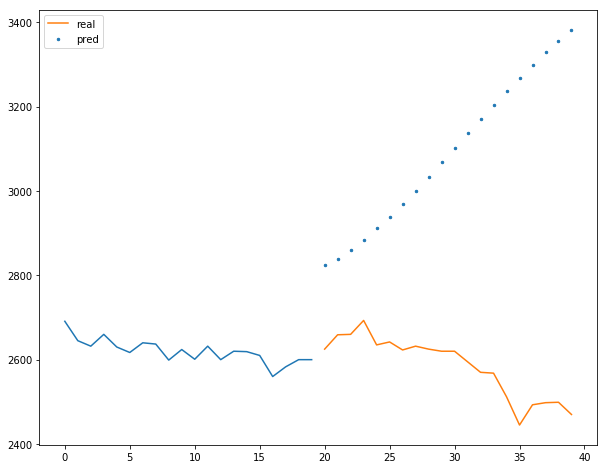

In [33]:
"""
In this section we visualize the results for a random test case. (from validation data)
"""
x_std = np.std(data, axis=0)
x_mean = np.mean(data, axis=0)
y_std = np.std(labels, axis=0)
y_mean = np.mean(labels, axis=0)
normalized = (data - x_mean) / x_std

i = 2605
example = normalized[i]

for j in range(20):
    pred = model.predict(example[j:, :].reshape(-1, 20, 5))
    example = np.concatenate((example, pred), axis=0)
un_example = example * y_std + y_mean

plt.plot(range(20), list(data[i, :, 3]))
plt.scatter(range(20,40), list(un_example[20:, 0]), s=6, label='pred')
plt.plot(range(20,40), list(data[20+i, :, 3]), label='real')
plt.legend()